In [14]:
%%capture
'''
(C) Copyright 2020-2025 Murilo Marques Marinho (murilomarinho@ieee.org)

     This file is licensed in the terms of the
     Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)
     license.

 Derivative work of:
 https://github.com/dqrobotics/learning-dqrobotics-in-matlab/tree/master/robotic_manipulators
 Contributors to this file:
     Murilo Marques Marinho (murilomarinho@ieee.org)
'''

# DQ5 Robot Control Basics using DQ Robotics - Part 1

## I found an issue
Thank you! Please report it at https://github.com/MarinhoLab/OpenExecutableBooksRobotics/issues

$\providecommand{\myvec}[1]{{\mathbf{\boldsymbol{{#1}}}}}$
$\providecommand{\mymatrix}[1]{{\mathbf{\boldsymbol{{#1}}}}}$
$\providecommand{\quat}[1]{{\mathbf{\boldsymbol{{#1}}}}}$
$\providecommand{\dual}{\varepsilon}$


## Introduction

For now, we have studied how dual quaternions can be a powerful algebraic tool to represent interesting geometric elements, such as reference frames, planes, lines, and points.


In this lesson we will study the control of very basic robots.


As always, before we start, make essential installations and imports.


In [16]:
from dqrobotics import *

import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml" # Need to output animation's videos
import matplotlib.animation as anm
from functools import partial # Need to call functions correctly for matplotlib animations

import numpy as np

## Notation

Keep these in mind (we will also use this notation when writing papers to conferences and journals):

-  $h\in \mathbb{H}$ : a quaternion. (Bold-face, lowercase character)
-  $\underline{h} \in \mathcal{H}$ : a dual quaternion. (Bold-face, underlined, lowercase character)
-  $p,t,\cdots \in {\mathbb{H}}_p$ : pure quaternions. They represent points, positions, and translations. They are quaternions for which $\textrm{Re}\left(h\right)=0$ .
-  $r\in {\mathbb{S}}^3$ : unit quaternions. They represent orientations and rotations. They are quaternions for which $||h||=1$ .
-  $\underline{x} \in$ $\underline{\mathcal{S}}$ : unit dual quaternions. They represent poses and pose transformations. They are dual quaternions for which $||h||=1$ .
-  $\underline{l} \in {\mathcal{H}}_p \cap$ $\underline{{\mathcal{S}}}$ : a Plücker line.
-  $\underline{{{\pi }}} \in \left\lbrace P\left(\underline{{{\pi }}} \right)\in {\mathbb{H}}_p \right\rbrace \cap \underline{{\mathcal{S}}}$ : a plane.

## Basics of Robot Kinematic Control

At this point, most robotics textbooks will introduce you to the kinematic modeling of robotic manipulators in detail.


Let us start with a one degree-of-freedom (DoF) planar robot, so that we can understand some major points regarding robotic control before we start making more complicated robotic modeling.

## 1-DoF planar robot

We start by defining the important reference frames, the robot, and the task we want to accomplish. We call this, "Problem Definition".

### Problem Definition
<p style="text-align:left">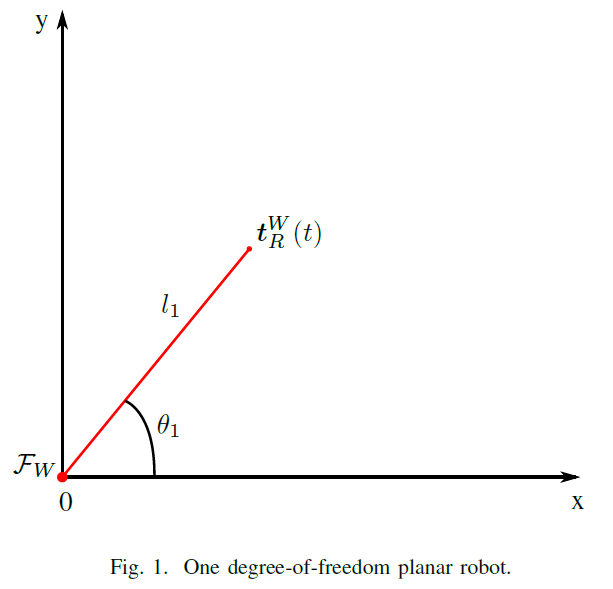</p>


1.  Let the robot $R$ be a 1-DoF planar robot, as drawn in Fig.1.
2. Let ${\mathcal{F}}_W$ be the world-reference frame.
3. Let ${\underline{x} }_R^W (t)$ $\in$ $\underline{\mathcal{S}}$ represent the time-dependent transformation from the origin of the world-reference frame to the tip of the robot. The tip of the robot is called *end effector*. Note that ${\underline{x} }_R^W (t)$ has a superscript "W" that means that the reference frame of this pose transformation is ${\mathcal{F}}_W$ . The subscript "R" means that, after the pose transformation, we will be at the end effector of the robot $R$ .
4. Let $R$ be composed of single link, actuated by a rotational joint that rotates about its z-axis by an angle $\theta_1 (t)\in \mathbb{R}$ . The reference frame of the joint coincides with ${\mathcal{F}}_W$ when $\theta_1 (t)=0$ . The length of the link is $l_1 \in$ ${\mathbb{R}}^+ -\lbrace 0\rbrace$ .
5. Consider that we can freely control the variable $\theta_1 (t)\triangleq \theta_1$ . The robot is said to have one degree-of-freedom because it has only one independent joint value.

Problems:

1.  Obtain the forward kinematic model and the inverse kinematic model of the robot $R$ that maps the joint value, $\theta_1 (t)$ , to the 3D translation of the end effector, $t_R^W (t)\triangleq \textrm{translation}\left({\underline{x} }_R^W \right)$ using unit dual quaternions. This can be easily found using simple trigonometry, but we will slowly move to more complicated examples.
2. Obtain the differential kinematic model and the inverse differential kinematic model of the robot $R$ .
3. Using 1. and 2., design an open-loop velocity controller in task-space.
4. Using 1. and 2., design a closed-loop position controller in task-space.
<a name="H_8AC9B033"></a>
### Forward Kinematic Model

The forward kinematic model (FKM), concerns finding the function that maps the *joint space* variables into the *task space* variables.

-  The joint space variables are all joint variables that we can control. In the current example, the joint space is only $\theta_1 (t)$ .
-  The task space variables depend on the task, but in general are the pose, the translation, the rotation, etc. of the end effector. In the current example, the task space is the end-effector's translation $t_R^W (t)$ .
-  The FKM answers the question: what is the end-effector {pose, translation, rotation, etc.}, given its joint values?

***Note the kinematic model of a robot models the motion of the robot without considering forces. It concerns only the geometry of the robot. This means that weight, inertia, and so on are not considered in kinematic modeling.***


The FKM of robot $R$ is quite straightforward, and can be found using two pose transformations.


$$t_R^W (t)=\textrm{translation}\left({\underline{x} }_1^W (\theta_1 ){\underline{x} }_R^1 (l_1 )\right),$$

where


$${\underline{x} }_1^W (\theta_1 )=\cos \left(\frac{\theta_1 }{2}\right)+\hat{k} \sin \left(\frac{\theta_1 }{2}\right),$$

is the rotation about the joint value (remember that the rotational joint pivots about its z-axis) and


$${\underline{x} }_R^1 (l)=1+\frac{1}{2}\varepsilon l_1 \hat{\imath} ,$$

is the translation of $l_1$ about the rotated x-axis.



<a name="H_AA707DEE"></a>
#### DQ Robotics Example

Let us create a class representing the 1-DoF planar robot. To keep our code organized, we write it in a separate file in snake case [one_dof_planar_robot.py]. The length of the robot does not change in time, so we add it as a class property.


Let us follow the [Google Python Style Guide](http://google.github.io/styleguide/pyguide.html#s3.16-naming) as much as possible, so that your code is readable.

1.  Class names should be written in camel-case, starting with an uppercase letter. For example "OneDofPlanarRobot".
2. Properties and methods should be written in lowercase, possibly using "_" if needed. For instance, "l", or "fkm()" or "my_favorite_method()"
3. Add comments to help other people understand what you are doing.



In [17]:
from one_dof_planar_robot import OneDofPlanarRobot
help(OneDofPlanarRobot)

Help on class OneDofPlanarRobot in module one_dof_planar_robot:

class OneDofPlanarRobot(builtins.object)
 |  OneDofPlanarRobot(l1)
 |
 |  OneDofPlanarRobot regarding all methods related to the 1-DoF planar robot
 |
 |  Methods defined here:
 |
 |  __init__(self, l1)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  fkm(self, theta1)
 |      Calculate the FKM for the 1-DoF planar robot.
 |
 |  ikm_tx(self, tx)
 |      Calculate the IKM for the 1-DoF planar robot using the
 |      desired x-axis translation.
 |
 |  ikm_ty(self, ty)
 |      Calculate the IKM for the 1-DoF planar robot using the
 |      desired y-axis translation.
 |
 |  plot(obj, theta1)
 |      Plot the 1-DoF planar robot in the xy-plane
 |
 |  translation_jacobian(self, theta1)
 |      Calculate the translation Jacobian of the 1-DoF planar
 |      robot.
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      di

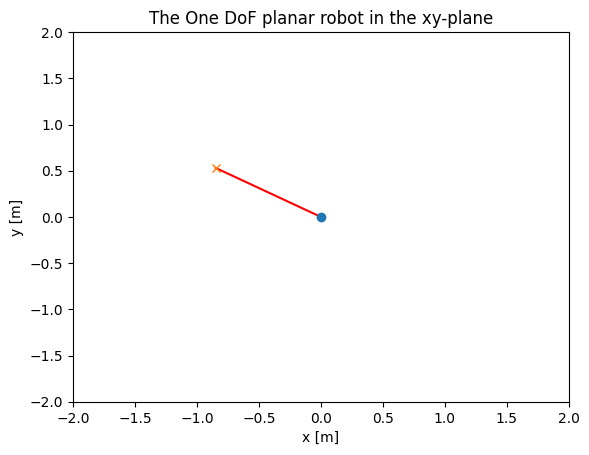

In [18]:
from one_dof_planar_robot import OneDofPlanarRobot

## Notice how easy it is to understand this code.
# Length
l1 = 1

# Create robot
one_dof_planar_robot = OneDofPlanarRobot(l1)

# Choose theta freely
theta1 =-3.7

# Get the fkm, based on theta
t_w_r = one_dof_planar_robot.fkm(theta1)

# Plot the robot in the xy-plane
plt.figure()
one_dof_planar_robot.plot(theta1)
plt.show()

<a name="H_42F7B7D9"></a>
### Inverse Kinematic Model

In most robotic control tasks, the task is defined in terms of the task-space variables, such as $t_R^W (t)$ , and not in terms of the joint-space variables, such as $\theta_1 (t)$ . For instance, "move the end effector to a given position".


The inverse kinematic model (IKM), concerns finding the opposite mapping of the FKM, that is, a function that maps the *task space* variables into joint space variables.

-  The FKM answers the question: what is the joint value I need so that the robot's end effector goes to a desired {pose, translation, rotation, etc.}?

We can start from the FKM


$$t_R^W (t)=\textrm{translation}\left({\underline{x} }_1^W (\theta_1 ){\underline{x} }_R^1 (l_1 )\right),$$

note that the total pose transformation is


$${\underline{x} }_1^W (\theta_1 ){\underline{x} }_R^1 (l_1 )=\left\lbrack \cos \left(\frac{\theta_1 }{2}\right)+\hat{k} \sin \left(\frac{\theta_1 }{2}\right)\right\rbrack +\frac{1}{2}\varepsilon l_1 \left\lbrack \hat{\imath} \cos \left(\frac{\theta_1 }{2}\right)+\hat{\jmath} \sin \left(\frac{\theta_1 }{2}\right)\right\rbrack$$

By the definition of the translation operation for any $\underline{x}$ $\in$ $\underline{\mathcal{S}}$


$$\textrm{translation}\left(\underline{x} \right)=2D\left(\underline{x} \right)P{\left(\underline{x} \right)}^*$$

Using the operation above and two trigonometric identities, we reach the following


$$t_R^W (t)=l_1 \left\lbrack \hat{\imath} \cos \left(\theta_1 \right)+\hat{\jmath} \sin \left(\theta_1 \right)\right\rbrack$$

This form is quite straightforward for us to find the IKM. Given that we the robot has only one degree-of-freedom, in this situation we can either choose to control the x-axis translation OR the y-axis translation. The other is defined by our initial choise.


For simplicity, let us define


$$t_R^W (t) = t_x \hat{\imath \;} +t_y \hat{\jmath \;} +t_z \hat{k} ,$$

where $t_x ,t_y ,t_z \in$ $\mathbb{R}$ represent the 3D coordinates of the robot's end effector.


Moreover, notice that, even in this very simple case, we have an issue. There are two possible values for $\theta_1$ that give us the same $t_x$ , and the same for $t_y$ . When finding an IKM, we have to simply choose one of the possible cases. We will adress alternative solutions afterwards, so in practice we almost never have to find the IKM explicitly.


If we decide to choose the x-axis translation, we have


$$t_x =l_1 \cos \left(\theta_1 \right)\iff \theta_1 =\arccos \left(\frac{t_x }{l_1 }\right)\iff t_y =l_1 \sin \left(\arccos \left(\frac{t_x }{l_1 }\right)\right)$$

And if we decide to choose the y-axis translation, we have


$$t_y =l_1 \sin \left(\theta_1 \right)\iff \theta_1 =\arcsin \left(\frac{t_y }{l_1 }\right)\iff t_y =l_1 \cos \left(\arcsin \left(\frac{t_y }{l_1 }\right)\right)$$

Note that, for all cases,


$$t_z =0.$$

When the robot does not have enough degrees-of-freedom for a specific task, we call it *underactuated*. In this case, the planar robot does not have enough degrees-of-freedom for us to freely choose the x-axis and y-axis translation simultaneously.

<a name="H_4B7E0016"></a>
#### DQ Robotics Example

The following methods are relevant

In [19]:
help(OneDofPlanarRobot.ikm_tx)

Help on function ikm_tx in module one_dof_planar_robot:

ikm_tx(self, tx)
    Calculate the IKM for the 1-DoF planar robot using the
    desired x-axis translation.



In [20]:
help(OneDofPlanarRobot.ikm_ty)

Help on function ikm_ty in module one_dof_planar_robot:

ikm_ty(self, ty)
    Calculate the IKM for the 1-DoF planar robot using the
    desired y-axis translation.




Suppose that $t_x$ is to be controlled.


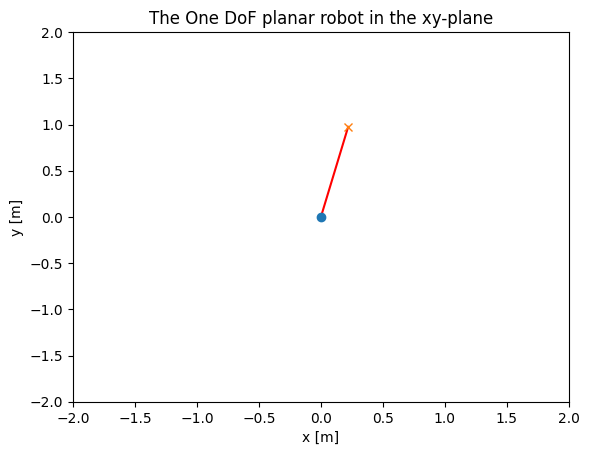

In [21]:
# Length
l1 = 1

# Create robot
one_dof_planar_robot = OneDofPlanarRobot(l1)

# Choose tx freely
tx =0.22

# Get the fkm, based on theta
theta1 = one_dof_planar_robot.ikm_tx(tx)

# Plot the robot in the xy-plane
one_dof_planar_robot.plot(theta1)


Now, suppose that $t_y$ is to be controlled.


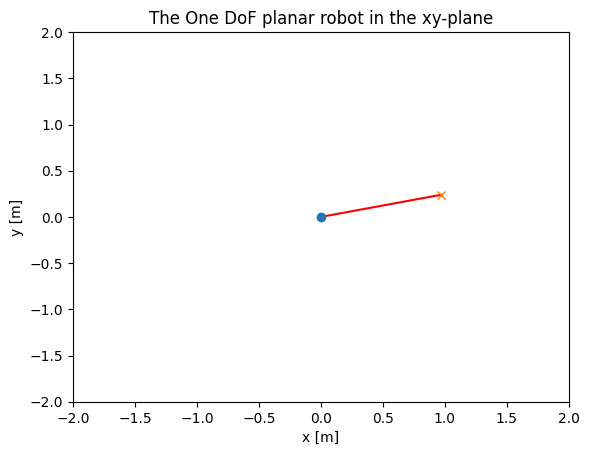

In [22]:
# Length
l1 = 1

# Create robot
one_dof_planar_robot = OneDofPlanarRobot(l1)

# Choose ty freely
ty = 0.24

# Get the fkm, based on theta
theta1 = one_dof_planar_robot.ikm_ty(ty)

# Plot the robot in the xy-plane
one_dof_planar_robot.plot(theta1)

<a name="H_10DF28F5"></a>
### Differential Kinematics Model

The first-order time-derivative of the FKM is called Differential Kinematics Model (DKM). It maps the joint-space velocities into task-space velocities. Although maybe not obvious at first glance, inverting the DKM is considerably easier than finding the IK high-DoF robots.


Back to our example, the DKM of the 1-DoF planar robot is the first-order time-derivative of the FKM


$${\dot{t} }_R^W (t)=l_1 \left\lbrack -\hat{\imath} \sin \left(\theta_1 \right)+\hat{\jmath} \cos \left(\theta_1 \right)\right\rbrack {\dot{\theta} }_1$$

Notice that it does not depend on the time-derivative of $l_1$ because $l_1$ does not vary on time (in this example). Let us call


$${{\jmath }}\left(\theta_1 \right)\triangleq l_1 \left\lbrack -\hat{\imath} \sin \left(\theta_1 \right)+\hat{\jmath} \cos \left(\theta_1 \right)\right\rbrack$$

then, our DKM becomes,


$${\dot{t} }_R^W (t)={{\jmath }}\left(\theta_1 \right){\dot{\theta} }_1$$

We can write this in matrix form as


$${\textrm{vec}}_3 \left\lbrack {\dot{t} }_R^W (t)\right\rbrack ={\textrm{vec}}_3 \left\lbrack {{\jmath }}\left(\theta_1 \right)\right\rbrack {\dot{\theta} }_1$$

In this case, the matrix


$$J_t \triangleq {\textrm{vec}}_3 \left\lbrack {{\jmath }}\left(\theta_1 \right)\right\rbrack$$

is, in general, called task Jacobian. Given that this specific Jacobian is related to the translation, we call it translation Jacobian. Note that the translation Jacobian depends on the joint value.

<a name="H_F168FD91"></a>
#### DQ Robotics Example

We add the following method to our 1-DoF planar robot.



In [23]:
help(OneDofPlanarRobot.translation_jacobian)

Help on function translation_jacobian in module one_dof_planar_robot:

translation_jacobian(self, theta1)
    Calculate the translation Jacobian of the 1-DoF planar
    robot.



In [24]:
# Length
l1 = 1

# Create robot
one_dof_planar_robot = OneDofPlanarRobot(l1)

# theta1, in rad
theta1 = -3.15
# theta1_dot, in rad/s
theta1_dot = 0.36

# Get the translation jacobian, based on theta
Jt = one_dof_planar_robot.translation_jacobian(theta1)

# Get the corresponding end effector velocity
print("Corresponding end effector velocity")

t_dot = Jt * theta1_dot
print(f"t_dot = {t_dot}")

Corresponding end effector velocity
t_dot = [-0.00302661 -0.35998728 -0.        ]


<a name="H_9D0F3DBF"></a>
### Inverse Differential Kinematics Model

The inverse differential kinematics model (IDKM) is the inverse relation of the DKM: it maps task-space velocities into joint-space velocities.


By inspecting our DKM, see how easy it is to invert the relation. We just need to left-multiply the equation by some type of inverse of the translation Jacobian. For instance, we can choose


$$J_t^{\textrm{inv}} \left(\theta_1 \right)={\textrm{vec}}_3 \left\lbrack \frac{-\hat{\imath} \sin \left(\theta_1 \right)+\hat{\jmath} \cos \left(\theta_1 \right)}{l_1 }\right\rbrack$$

which results in


$${\dot{\theta} }_1 =J_t^{\textrm{inv}} \left(\theta_1 \right){\dot{t} }_R^W (t).$$

In practice, instead of finding a pseudo-inverse algebraically, we use numerical methods to find the (pseudo) inverse of the task Jacobian.


 ***Note: You certainly learned already that the inverse of a matrix only exists when the matrix is square and full-rank. For all other cases, you can resort to pseudo-inverses.***

<a name="H_DF5007EA"></a>
#### DQ Robotics Example

Using `dqrobotics.utils.DQ_LinearAlgebra`, we have an implementation of the singular-value decomposition pseudo-inverse to calculate the IDKM called `pinv`.


In [25]:
from dqrobotics.utils.DQ_LinearAlgebra import pinv

# Length
l1 = 1

# Create robot
one_dof_planar_robot = OneDofPlanarRobot(l1)

# theta1, in rad
theta1 = -2.27

# vx, in m/s
vx = -0.19
# vy, in m/s
vy = 0.74
# vz, in m/s
vz = -0.71

# Compose the end effector velocity into a pure quaternion
t_dot = vx*i_ + vy*j_ + vz*k_
print(f"t_dot = {t_dot}")

# Get the translation jacobian, based on theta
Jt = one_dof_planar_robot.translation_jacobian(theta1)

# Get the corresponding joint velocity
print("Corresponding joint velocity")
theta_dot = pinv(Jt) @ vec3(t_dot)
print(f"theta_dot = {theta_dot}")

t_dot =  - 0.19i + 0.74j - 0.71k
Corresponding joint velocity
theta_dot = [-0.62168767]


<a name="H_C017FE25"></a>
### Task-space Velocity Control using the IDKM

We are now equipped to design a simple open-loop task-space velocity controller.

In our example with the 1-DoF planar robot, let the goal be to have the a constant task-space velocity, ${\dot{t} }_d \in {\mathbb{H}}_p$ .

Given the open-loop design, we can directly plug in the desired task-space velocity in the IDKM, which results in

$${\dot{\theta} }_1 (t)=J_t^{\textrm{inv}} \left(\theta_1 (t)\right){\textrm{vec}}_3 \left({\dot{t} }_d \right).$$

Some robots will allow you to control the joint velocity directly. However, for some robots you will only be able to control the joint positions. In this case, you can discretize the controller as follows

$$\theta_1 (t+\tau )=\theta_1 (t)+\tau \left\lbrack J_t^{\textrm{inv}} \left(\theta_1 (t)\right){\dot{t} }_d \right\rbrack ,$$

where $\tau \in {\mathbb{R}}^+ -\lbrace 0\rbrace$ is the sampling time.

#### DQ Robotics Example

For the following example, the discretized version of the open-loop velocity controller was implemented. You can change `vx`, `vy`, and `vz`.

In [26]:
# Length
l1 = 1

# Sampling time [s]
tau = 0.001

# Final time [s]
time_final = 0.25

# Number of iterations
n_iterations = len(np.arange(0,time_final+tau,tau))

# Create robot
one_dof_planar_robot = OneDofPlanarRobot(l1)

# Initial joint value [rad]
theta1 = -3.58

## Desired task-space velocity
# vx [m/s]
vx = 3.29
# vy [m/s]
vy = 3.7
# vz [m/s]
vz = 3.5

# Compose the end effector velocity into a pure quaternion
td_dot = vx*i_ + vy*j_ + vz*k_

# Store the current task-space velocity and the desired task-space velocity
stored_td_dot = []
stored_t_dot = []
stored_time = []
stored_q = []

# Open Loop Velocity Control, run from t=0 to t=t_final
print(f'Running control loop for {n_iterations} iterations.')

time = 0

for i in np.arange(0,time_final+tau,tau):
    # Store theta so that we can animate the robot later
    stored_q.append(theta1)

    # Get the translation jacobian, based on theta
    Jt = one_dof_planar_robot.translation_jacobian(theta1)

    # Calculate the IDKM
    theta1_dot = pinv(Jt) @ vec3(td_dot)

    # Move the robot
    theta1 = theta1 + theta1_dot * tau

    # Store the variables so that we can analise the simulation results
    stored_td_dot.append(vec3(td_dot))
    stored_t_dot.append(Jt*theta1_dot) # We find the actual task velocity using the DKM
    stored_time.append(time)

    # Update time
    time = time + tau

# Animation function for pyplot
def animate_robot(n):
    plt.cla()
    one_dof_planar_robot.plot(stored_q[n])

# Create pyplot figure and run animation
fig = plt.figure()
anm.FuncAnimation(fig, animate_robot, frames=len(stored_q))

Running control loop for 251 iterations.


TypeError: only 0-dimensional arrays can be converted to Python scalars


We can plot the results of the simulations using the following function, which was implemented in `plot_td_dot_and_t_dot.py`


In [ ]:
# Plot desired and current task-space velocities
from plot_td_dot_and_t_dot import plot_td_dot_and_t_dot
plot_td_dot_and_t_dot(np.array(stored_td_dot), 
                      np.array(stored_t_dot), 
                      np.array(stored_time))


Note that, in general, this simple robot cannot mantain the desired velocity. The main reason for this is the geometry of the 1-DoF planar robot. As shown in detail when the IK was calculated, the velocity in the x-axis and the y-axis are coupled. In addition, we cannot control the velocity in the z-axis.

### Task-space position control using the IDKM

Controlling the task-space variables (translation, rotation, or pose)  directly is in general more useful than controlling their velocities.


In our example with the 1-DoF planar robot, let the goal be to reach a given task-space translation, $\quat{t}_d \in {\mathbb{H}}_p$ .


To do so, we start with the IDKM


$${\dot{\theta} }_1 (t) = \mymatrix{J}_t^{\textrm{inv}} \left(\theta_1(t)\right){\textrm{vec}_3\dot{\quat{t}}}_R^W(t).$$

Remember that we can freely choose a ${\dot{\quat{t}} }_R^W (t)$ that is relevant to our task. Let us choose


$${\dot{\quat{t}}}_R^W (t)=-\eta \left(t_R^W -{{\quat{t}_d}}\right),$$

with $\eta \in {\mathbb{R}}^+ -\lbrace 0\rbrace$ . The parameter $\eta$ is used to control the convergence speed.

The position controller becomes

$${\dot{\theta} }_1 (t)=-\eta \mymatrix{J}_t^{\textrm{inv}} \left(\theta_1 \right){\textrm{vec}}_3\tilde{\quat{t}} ,$$

for  $\tilde{t} =\left(t_R^W -{{t_d}}\right)$ .

Note that $\tilde{t}$ is a vector that points from the current end-effector position to the desired end-effector position. It is a type of error function.

#### Error convergence

When designing controllers, it is important to guarantee that error norm converges to zero when time tends to infinity. In our example, this means


$$\lim_{t\to \infty } \tilde{t} \left(t\right)=0$$

When can show that this is true by inspecting the error dynamics under certain assumptions. We do that by getting the first-order time-derivative of the error function. In our example,


$$\dot{\tilde{t} } ={\dot{t} }_R^W -{\dot{t} }_d ={\dot{t} }_R^W$$

because the desired translation does not vary on time. Then, we can substitute the DKM to find


$${\textrm{vec}}_3 \dot{\tilde{t} } =J_t {\dot{\theta} }_1$$

then, we can replace our controller


$${\textrm{vec}}_3 \dot{\tilde{t} } =-\eta \mymatrix{J}_t \mymatrix{J}_t^{\textrm{inv}} \left(\theta_1 \right){\textrm{vec}}_3 \tilde{t}$$

in general, we suppose that


$$\mymatrix{J}_t \mymatrix{J}_t^{\textrm{inv}} = \mymatrix{I}$$

where $\mymatrix{I}$ is the identity matrix of suitable size. Hence, we have that


$${\textrm{vec}}_3 \dot{\tilde{t} } =-\eta {\textrm{vec}}_3 \tilde{t} ,$$

Which means that the error exponentially converges to zero when time tends to infinity.


 ***Note: In fact, the equation*** $\mymatrix {J}_t \mymatrix{J}_t^{\textrm{inv}} = \mymatrix{I}$ ***does not hold in many situations (it also doesn't hold in our example, because of the coupling between the translations in the x-axis and the y-axis, and the z-axis translation can't be controlled at all).*** ***The point of this section is not to discuss this in detail, but just to give the reader a general idea of the reasoning behind task-space position control.***

#### DQ Robotics Example

In [ ]:
# Length
l1 = 1

# Sampling time [s]
tau = 0.001

# Control threshold [m/s]
control_threshold = 0.01

# Control gain
eta = 200

# Create robot
one_dof_planar_robot = OneDofPlanarRobot(l1)

# Initial joint value [rad]
theta1 = 0

# Desired task-space position
# tx [m]
tx = 1.21
# vy [m]
ty =1

# Compose the end effector position into a pure quaternion
td = DQ([tx, ty, 0])

# Position controller. The simulation ends when the
# derivative of the error is below a threshold
time = 0
t_error_dot = DQ([1]) # Give it an initial high value
t_error = DQ([1]) # Give it an initial high value

# For animation
stored_q = []

while np.linalg.norm(vec4(t_error_dot)) > control_threshold:
    # Store theta so that we can animate the robot later
    stored_q.append(theta1)

    # Get the current translation
    t = one_dof_planar_robot.fkm(theta1)

    # Calculate the error and old error
    t_error_old = t_error
    t_error = (t-td)
    t_error_dot = (t_error-t_error_old)*(1.0/tau)

    # Get the translation jacobian, based on theta
    Jt = one_dof_planar_robot.translation_jacobian(theta1)

    # Calculate the IDKM
    theta1_dot = -eta * pinv(Jt) @ vec3(t_error)

    # Move the robot
    theta1 = theta1 + theta1_dot * tau

def animate_robot2(n, tx, ty):
    plt.cla()
    plt.plot(tx,ty,'b+')
    one_dof_planar_robot.plot(stored_q[n])

fig = plt.figure()
anm.FuncAnimation(fig, partial(animate_robot2, tx=tx, ty=ty), frames=len(stored_q))

# Homework

(1) Following the format of [OneDofPlanarRobot.m], create a class called [TwoDofPlanarRobot.m] that represents a 2-DoF planar robot as shown in the following figure $l_1 ,l_2 \in {\mathbb{R}}^+ -0$ and $\theta_1 ,\theta_2 \in \mathbb{R}$ .

<p style="text-align:left">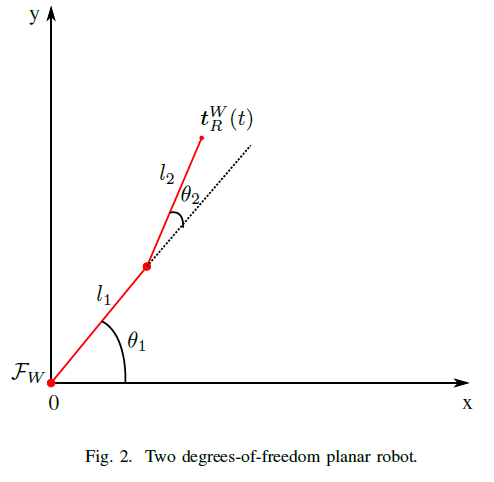</p>


The class must have

1. A constructor that takes $l_1 ,l_2$ as inputs.
2. A function that calculates the forward kinematics model (FKM) of the robot.
3. A function that calculates the translation Jacobian of the robot.
4. A plot function that plots the robot in 2D space.

**Note: You do** ***NOT*** **need to implement the IK function.**

(2) With the class you created in (1), create a script called `two_dof_planar_robot_position_control.py` that implements a task-space translation controller. Control the robot from the initial posture $\theta_1 (0)=0,\theta_2 (0)=\frac{\pi }{2}$ to $t_d =2\hat{\jmath}$ .

